In [1]:
import numpy as np
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import pymde
import ot
import pandas as pd

/data/gpfs/projects/punim0638/stephenz/miniconda3/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libjpeg.so.8: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
2023-10-17 07:35:30.719285: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-17 07:35:31.433175: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-17 07:35:32.791341: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-17 07:35:32.792394: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instruction

In [15]:
DATA_PATH="../data/simulated/Synthetic_2000/dyn-BFStrange/dyn-BFStrange-2000-1/"
FIG_DIR = "./"

In [16]:
adata = ad.read_h5ad(DATA_PATH + "anndata.h5ad")
sc.tl.tsne(adata, perplexity = 250, random_state = 0)

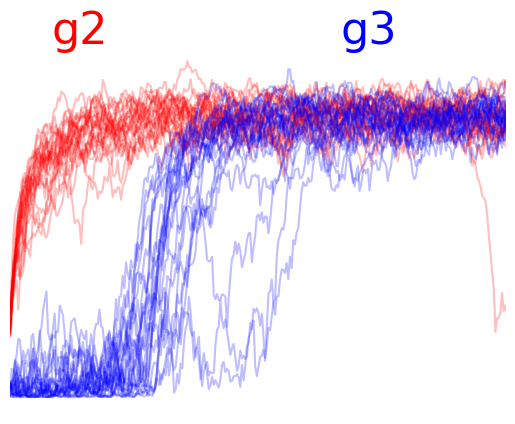

In [78]:
# plot genes 2, 3
x_g2 = np.vstack([pd.read_csv(DATA_PATH + "../simulations/E%d.csv" % i, index_col = 0).iloc[1, :].to_numpy() for i in range(25)])
x_g3 = np.vstack([pd.read_csv(DATA_PATH + "../simulations/E%d.csv" % i, index_col = 0).iloc[2, :].to_numpy() for i in range(25)])

eta = 0.1

x=np.log(eta + x_g2).T
y=np.log(eta + x_g3).T

plt.plot(np.linspace(0, 1, x_g2.shape[1]), x, c = "red", alpha = 0.25);
plt.plot(np.linspace(0, 1, x_g2.shape[1]), y, c = "blue", alpha = 0.25);
plt.text(0.025, 1.5, "g2", color = "red", size = 32)
plt.text(0.2, 1.5, "g3", color = "blue", size = 32)
plt.axis("off")
plt.xlim(0, 0.3)
plt.savefig(FIG_DIR + "te.pdf")

In [79]:
np.save("x.npy", x)
np.save("y.npy", y)

In [95]:
P = np.linalg.matrix_power(np.load(DATA_PATH + "P_statot.npy"), 3)
pi_unif = np.full(adata.shape[0], 1/adata.shape[0])
Q = (P.T * pi_unif)/(pi_unif @ P).T;
C = np.load(DATA_PATH + "C.npy")
C /= C.mean()

In [96]:
from julia import Base, OptimalTransport

In [97]:
pi0 = ot.smooth.smooth_ot_dual(np.full(C.shape[0], 1.0), np.full(C.shape[0], 1.0), C, 0.5, numItermax = 1_000)
# pi0 = ot.sinkhorn(np.full(C.shape[0], 1/C.shape[0]), np.full(C.shape[0], 1/C.shape[0]), C, 0.025)
# pi0 = OptimalTransport.quadreg(np.full(C.shape[0], 1), np.full(C.shape[0], 1), C, 2.5)

(-5.787783193588257, 7.35145525932312, -10.285671401023865, 6.843694376945495)

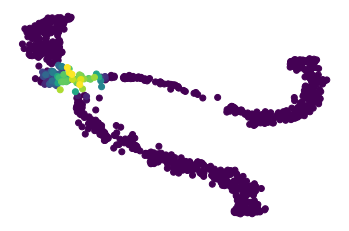

In [98]:
cell_idx = 255
p = pi0[np.argsort(adata.obs.dpt)[cell_idx], :]
p /= p.sum()
plt.scatter(adata.obsm["X_tsne"][np.argsort(p), 0], adata.obsm["X_tsne"][np.argsort(p), 1], c = np.sort(p))
plt.axis("off")

(-5.787783193588257, 7.35145525932312, -10.285671401023865, 6.843694376945495)

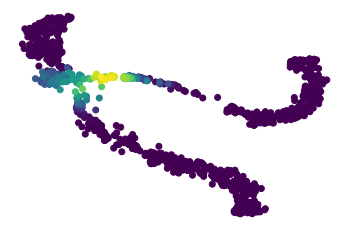

In [99]:
p = pi0[np.argsort(adata.obs.dpt)[cell_idx], :] @ P
p /= p.sum()
plt.scatter(adata.obsm["X_tsne"][np.argsort(p), 0], adata.obsm["X_tsne"][np.argsort(p), 1], c = np.sort(p))
plt.axis("off")

(-5.787783193588257, 7.35145525932312, -10.285671401023865, 6.843694376945495)

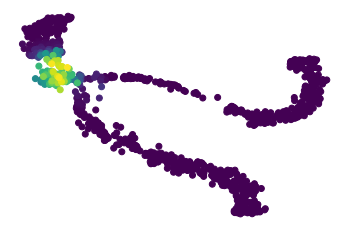

In [100]:
p = pi0[np.argsort(adata.obs.dpt)[cell_idx], :] @ Q
p /= p.sum()
plt.scatter(adata.obsm["X_tsne"][np.argsort(p), 0], adata.obsm["X_tsne"][np.argsort(p), 1], c = np.sort(p))
plt.axis("off")

In [101]:
import networkx as nx
G_all = [np.load(DATA_PATH + "G_illustration_%d.npy" % i) for i in [0, 1, 2]]
G_avg = sum(G_all)/3
g = nx.DiGraph(G_avg)
g = nx.relabel_nodes(g, {i : i+1 for i in range(len(g.nodes))})
pos = nx.spring_layout(g)

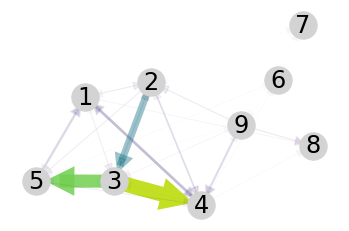

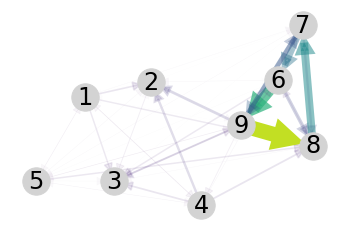

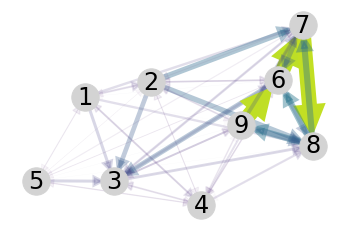

In [102]:
import matplotlib
for idx, G in enumerate(G_all):
    g = nx.DiGraph(G)
    g = nx.relabel_nodes(g, {i : i+1 for i in range(len(g.nodes))})
    edges,weights = zip(*nx.get_edge_attributes(g,'weight').items())
    weights = np.array(list(weights))
    weights /= np.max(weights)
    plt.figure()
    nx.draw_networkx_nodes(g, pos, node_color = "lightgrey", node_size = 750)
    arrows = nx.draw_networkx_edges(g, pos, edge_color = weights, alpha = weights, width = 15*weights, edge_cmap = matplotlib.colormaps["viridis"], edge_vmax = 1.1)
    for a, w in zip(arrows, weights):
        # from https://stackoverflow.com/questions/67251763/how-to-obtain-non-rounded-arrows-on-fat-lines
        a.set_mutation_scale(20 + w)
        a.set_joinstyle('miter')
        a.set_capstyle('butt')
    nx.draw_networkx_labels(g, pos, font_size = 24);
    plt.axis("off")
    plt.savefig(FIG_DIR + "network_%d.pdf" % idx)

In [103]:
G = np.load(DATA_PATH + "G.npy")
G = np.swapaxes(G.reshape(-1, adata.shape[1], adata.shape[1]), 1, 2).reshape(-1, adata.shape[1]**2) # fix Julia orientation

In [104]:
g = nx.DiGraph(np.mean(G[adata.obs.dpt < 0.9, :], axis = 0).reshape(adata.shape[1], adata.shape[1]))

(-1.2100000000000002,
 1.2100000000000002,
 -1.2100000000000002,
 1.2100000000000002)

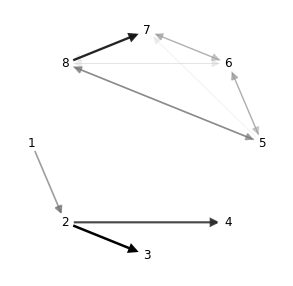

In [105]:
import itertools
# get weights from g
edges,weights = zip(*nx.get_edge_attributes(g,'weight').items())
weights = np.array(list(weights))
weights /= np.max(weights)
# node and edgelist
nl = list(g.nodes())
el = list(g.edges())
edge_idx = np.where(weights > np.quantile(weights, 0.8))[0]
edgelist = [el[i] for i in edge_idx]
node_idx = list(set(itertools.chain(*edgelist)))
nodelist = [nl[i] for i in node_idx]
# take subgraph
g_sub = g.subgraph(nodelist)

# now plot
edges,weights = zip(*nx.get_edge_attributes(g_sub,'weight').items())
weights = np.array(list(weights))
weights /= np.quantile(weights, 0.999)
weights = np.minimum(1, weights)
edge_idx2 = np.where([e in edgelist for e in g_sub.edges()])[0]

fig = plt.figure(figsize = (5, 5))
pos = nx.shell_layout(g_sub)
# nx.draw_networkx_nodes(g_sub, pos, node_color = "b", node_size = 5)
arrows = nx.draw_networkx_edges(g_sub, pos, edgelist = edgelist, edge_color = weights[edge_idx2], alpha = weights[edge_idx2], width = 2.5*weights[edge_idx2], edge_cmap = matplotlib.colormaps["Greys"], edge_vmin = 0)
for a, w in zip(arrows, weights):
    # from https://stackoverflow.com/questions/67251763/how-to-obtain-non-rounded-arrows-on-fat-lines
    a.set_mutation_scale(16 + w)
    a.set_joinstyle('miter')
    a.set_capstyle('butt')
nx.draw_networkx_labels(g_sub, pos, font_size = 12);
plt.axis("off")

(-0.5, 999.5, 13.5, -0.5)

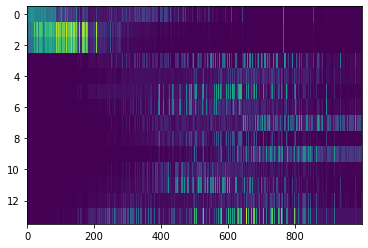

In [106]:
G_tensor = G.reshape(-1, adata.shape[1], adata.shape[1])
G_subset = np.vstack([G_tensor[:, i, j] for (i, j) in edgelist])
plt.imshow(G_subset[:, np.argsort(adata.obs.dpt)], interpolation = "none")
plt.axis("auto")

In [107]:
import seaborn as sb
import pygam
gams = [pygam.LinearGAM(pygam.s(0)).fit(adata.obs.dpt, x) for x in G_subset]
G_gam = np.vstack([g.predict(adata.obs.dpt) for g in gams])
# G_gam /= G_gam.sum(-1).reshape(-1, 1)
row_perm = np.argsort(np.mean(G_gam * np.array(adata.obs.dpt).reshape(1, -1), -1))

/home/stephenz/base_env/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(327.99999999999994, 0.5, 'Interaction')

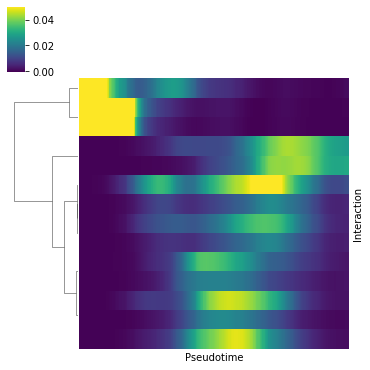

In [108]:
import scipy
cg = sb.clustermap(G_gam[:, np.argsort(adata.obs.dpt)], col_cluster = False, metric = "correlation", xticklabels = False, yticklabels = False, figsize = (5, 5), cmap = "viridis", vmax = 0.05)
cg.ax_heatmap.set_xlabel("Pseudotime")
cg.ax_heatmap.set_ylabel("Interaction")

(-1.2100000000000002,
 1.2100000000000002,
 -1.2100000000000002,
 1.2100000000000002)

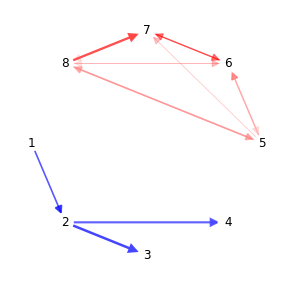

In [109]:
active_dpt = np.array(adata.obs.dpt)[np.argsort(G_gam, -1)[:, -1]]

fig = plt.figure(figsize = (5, 5))
pos = nx.shell_layout(g_sub)
# nx.draw_networkx_nodes(g_sub, pos, node_color = "b", node_size = 5)
arrows = nx.draw_networkx_edges(g_sub, pos, edgelist = edgelist, edge_color = active_dpt, alpha = weights[edge_idx2], width = 2.5*weights[edge_idx2], edge_cmap = matplotlib.colormaps["bwr"])
for a, w in zip(arrows, weights):
    # from https://stackoverflow.com/questions/67251763/how-to-obtain-non-rounded-arrows-on-fat-lines
    a.set_mutation_scale(16 + w)
    a.set_joinstyle('miter')
    a.set_capstyle('butt')
nx.draw_networkx_labels(g_sub, pos, font_size = 12);
plt.axis("off")